In [123]:
import glob, os, random, re, sys, math, warnings
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

from czifile import imread
from matplotlib.patches import Patch
from scipy.signal import convolve2d
from scipy import stats
from skimage import io, feature, filters, segmentation, morphology, measure
from sklearn.cluster import k_means
from ipywidgets import interact, widgets
from IPython.display import set_matplotlib_formats

import interaction_factor as IF
from img2mask import img2mask
from fixed_cell_tools import *

In [2]:
%matplotlib inline
sns.set_context("notebook")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

In [1]:
#TODO – add features to algorithmic spot detection

# Fixed cell image analysis notebook
<a id='section0'></a>
***

## Analysis overview

1. [Image import](#section1)
2. [DAPI-gated cellular segmentation](#section2)
3. [Spot detection](#section3)
4. [Colocalization analysis](#section4)
5. [Cell-to-cell measurements](#section5)
6. [Batch processing](#section6)


Some of the subsequent code was adapted from the European Molecular Biology Laboratory, Jonas Hartmann, Karin Sasaki, Toby Hodges (© 2018, for cellular segmentation) and from Justin Bois, California Institute of Technology (© 2015, for colocalization in #Functions). Detailed documentation for each function can be found in the accompanying `colocalization.py` file. Everything is distributed under a MIT license.

## 1. Image import
<a id='section1'></a>

First, the images are imported as numpy array. The filetype must be specified in order to import the correct images. Once imported, the images are displayed for visual inspection. To avoid relabeling, the channels should be labeled as indicated below.

0. Channel – Used for segmentation (nuclear mark)
1. Channel – Colocalization 1 (and spot counting)
2. Channel – Colocalization 2 (and spot counting)
3. Channel – Possible thresholding

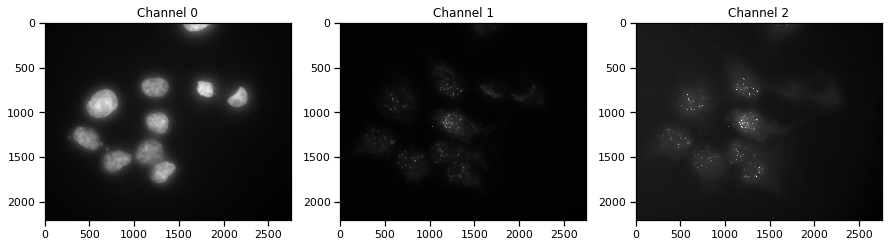

In [6]:
root = '/Users/beichenberger/Downloads/test/'
file_number = 0
czi = True
sharp = False
sharp_channel = 0
order = [2, 0, 1]

files = get_files(root, czi=czi)
img = import_images(files[file_number], sharp=sharp, sharp_channel=sharp_channel, czi=czi, order=order)

# Visualization
fig, ax = plt.subplots(1, len(img), figsize=(15, 10))
for i, image in enumerate(img):
    ax[i].set_title(f'Channel {i}')
    ax[i].imshow(image, interpolation=None, cmap='gray')
plt.show()

## 2. DAPI-gated cellular segmentation
<a id='section2'></a>

To do a cellular analysis, all cells are segmented. Segmentation is performed on a acquisition channel with labeled nuclei. This allows for simpler distinguishing between individual cells. The parts of this multi-step process are described below. Alternatively, the speedrun can be used which combines all individual steps performed below.

### 2.0 Speedrun

In [7]:
img0_seg, img0_nuclei = segment(img[0],
                                img_bg=img[1],
                                img0_sigma=5,
                                img0_min_size=300,
                                img0_min_distance=50,
                                img0_thresh_bg=500,
                                img0_min_size_bg=1_000)

### 2.1 Preprocessing
To obtain a better segmentation later on, the image acquired through the DAPI channel will be smoothed by a gauss filer. Different sigmas (below) can be used to change 'smoothing intensity'.

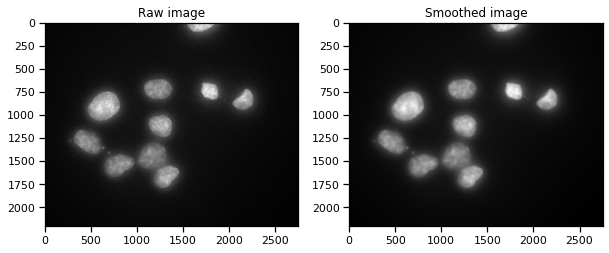

In [20]:
# Gauss-smoothening
img0_sigma = 5
img0_smooth = ndi.filters.gaussian_filter(img[0], img0_sigma)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Raw image')
ax[0].imshow(img[0], interpolation='none', cmap='gray')
ax[1].set_title('Smoothed image')
ax[1].imshow(img0_smooth, interpolation='none', cmap='gray')
plt.show()

### 2.2 Thresholding
A global threshold will be applied to remove background noise and to be left with the DAPI nuclei. A variety of thresholding options can be selected. Currently 'otsu' is used.

In [ ]:
img0_min_size = 300

# Thresholding and removal of small objects
img0_thresh = filters.threshold_otsu(img0_smooth)
img0_smooth_thresh = img0_smooth>img0_thresh
img0_smooth_thresh_fill = ndi.binary_fill_holes(img0_smooth_thresh).astype(bool)
img0_nuclei = morphology.remove_small_objects(img0_smooth_thresh_fill, img0_min_size)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Raw image')
ax[0].imshow(img[0], interpolation='none', cmap='gray')
ax[1].set_title('Thresholded DAPI')
ax[1].imshow(img0_nuclei, interpolation='none', cmap='gray')
plt.show()

### 2.3 Connected component labeling
As some DAPI nuclei currently show up to be combined, a further smoothing and a exact euclidean distance transform is used to separate these combined nuclei. Thereby, undersegmentation artifacts can be minimized.

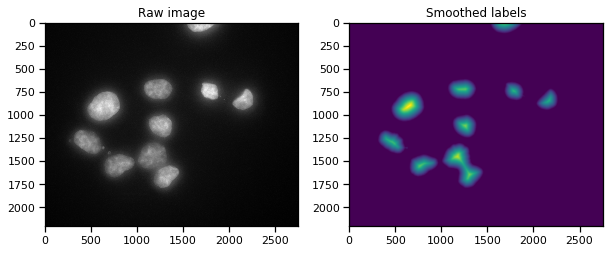

In [21]:
# Labeling, euclidean distance transform, smoothing
img0_dist_trans = ndi.distance_transform_edt(img0_nuclei)
img0_dist_trans_smooth = ndi.filters.gaussian_filter(img0_dist_trans, sigma=img0_sigma)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Raw image')
ax[0].imshow(img[0], interpolation='none', cmap='gray')
ax[1].set_title('Smoothed labels')
ax[1].imshow(img0_dist_trans_smooth, interpolation='none', cmap='viridis')
plt.show()

### 2.4 Seeding
Local maxima are used to detect every DAPI nucleus. This provides a seed for the later segmentation.

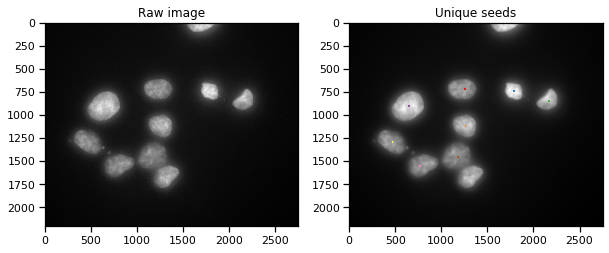

In [22]:
img0_min_distance = 50

# Seeding (and dilating for visualization)
img0_seeds = feature.peak_local_max(img0_dist_trans_smooth, indices=False, min_distance=img0_min_distance)
img0_seeds_labeled, _ = ndi.label(img0_seeds)

vis_size = 20
img0_seeds_labeled_dil = ndi.filters.maximum_filter(img0_seeds_labeled, size=vis_size)
img0_seeds_vis = np.ma.array(img0_seeds_labeled_dil, mask=img0_seeds_labeled_dil==0)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Raw image')
ax[0].imshow(img[0], interpolation='none', cmap='gray')
ax[1].set_title('Unique seeds')
ax[1].imshow(img0_dist_trans_smooth, interpolation='none', cmap='viridis')
ax[1].imshow(img0_smooth, interpolation='none', cmap='gray')
ax[1].imshow(img0_seeds_vis, interpolation='none', cmap='Set1')
plt.show()

### 2.5 Cytoplasmic extraction

To segment the cytoplasm, a second channel is typically used. After thresholding to remove background noise, small objects (high intensity noise) get filtered out. Subsequently, the entire cell is 'dilated'. This makes sure the entire cytoplasm is included and fills up uneven cellular borders which might be suboptimal for downstream analyses.

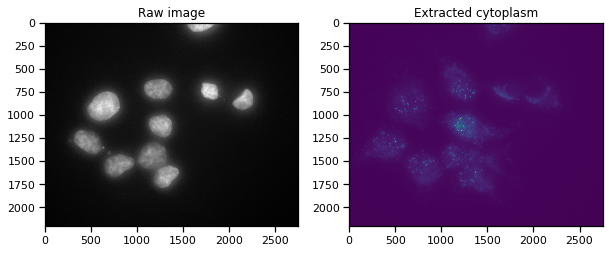

In [146]:
img0_thresh_bg = 500
img0_min_size = 10_000
img0_dil = 5

# Treshold background
img1_thresh = img[1]>img0_thresh_bg

# Remove small objects
img1_objects = morphology.remove_small_objects(img0_smooth_thresh_bg, min_size=10_000) 

# Dilute cells
img1_kernel = morphology.selem.diamond(5)
img1_dil = convolve2d(img0_smooth_objects.astype(int), img0_kernel.astype(int), mode='same').astype(bool)

# Add back values
img1_cyto = img0_dil * img[1]

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Raw image')
ax[0].imshow(img[0], interpolation='none', cmap='gray')
ax[1].set_title('Extracted cytoplasm')
ax[1].imshow(img1_cyto, interpolation='none', cmap='viridis')
plt.show()

### 2.5 Inverted watershed

Actual segmentation using the generated seeds and the extracted cytoplasm. An inverted watershed or random walker can be used. Cells on the border might slightly skew with the results, but because a 63x objective is required to visualize the FISH spots, removing these cells would result in only very few (if any) cells remaining per image. Furthermore colocalization is analyzed and not total spot count.

Finally, the generated cytoplasmic areas are added back to remove the background (resulting from the watershed segmentation).

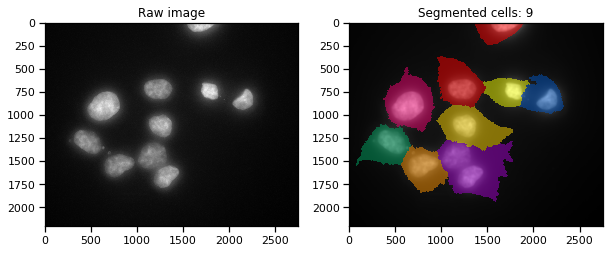

In [156]:
# Inverted watershed for segmentation
img0_seg = segmentation.watershed(~img1_cyto, img0_seeds_labeled)
img0_seg *= img1_dil

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Raw image')
ax[0].imshow(img[0], interpolation='none', cmap='gray')
ax[1].set_title(f'Segmented cells: {len(np.unique(img0_seg)[1:])}')
ax[1].imshow(img0_smooth, interpolation='none', cmap='gray')
ax[1].imshow(np.ma.array(img0_seg, mask=img0_seg==0), interpolation='none', cmap='prism', alpha=0.5)
plt.show()

## 3. Spot detection
<a id='section3'></a>

To find optimal spot detection parameters in the second image channel, the widgets below can be used. Beside, the three main methods, one can find the nuclear localization and nearest neighbor (closest spot in another channel).

### 3.1 Detection methods

#### 3.1.1 Traditional

**Set intensity thresholds** – Set a threshold to cut off low intensity patches.

**Filter spots** – A size and circularity threshold can be set. The alternative would be to use a rolling ball. The current python implementation, however, uses nested for-loops and is very inefficient. If there are any faster implementations, one could consider changing.

In [124]:
def test_spot_counter(image, thresh_bg, img_size, img_circ):
    # Threshold
    img_thresh = image>thresh_bg
    
    # Ignore div/ by zero warning and calculate circularity
    warnings.filterwarnings("ignore", message="divide by zero encountered")
    circ = lambda r: (4 * math.pi * r.area) / (r.perimeter * r.perimeter)
    
    # Generate labels
    img_seg, _ = ndi.measurements.label(img_thresh)
    img_seg = measure.label(img_thresh, connectivity=1)
    
    # Exclude regions outside of thresholds C1
    for label, region in enumerate(measure.regionprops(img_seg)):
        label_size = region.area
        label_circ = region.perimeter or circ(region)
        if not (label_size >= img_size[0] and
            label_size <= img_size[1] and
            label_circ >= img_circ[0] and
            label_circ <= img_circ[1]):
            img_seg[img_seg == label] = 0
    
    vis_size = 10
    seeds_dil = ndi.filters.maximum_filter(img_seg, size=vis_size)
    seeds_vis = np.ma.array(seeds_dil, mask=seeds_dil==0)
    seeds_unique = len(np.unique(img_seg)[1:])
    
    # Visualization
    plt.figure(figsize=(10, 10))
    plt.title(f'Detected spots: {seeds_unique}')
    plt.imshow(image, interpolation='none', cmap='gray')
    plt.imshow(seeds_vis, interpolation='none', cmap='prism', alpha=0.5)
    plt.show()

In [125]:
@interact(t_channel = widgets.ToggleButtons(options=['1', '2'], description='Channel: '),
          t_thresh_bg = widgets.IntSlider(min=0, max=20_000, step=50, value=5000, description='Threshold: '),
          t_size = widgets.IntRangeSlider(min=0, max=5_000, step=10, value=[0, 5_000], description='Size: '),
          t_circ = widgets.FloatRangeSlider(min=0, max=10, step=0.05, value=[0, 10], description='Circularity: '))
          
def g(t_channel, t_thresh_bg, t_size, t_circ):
    t_img = img[int(t_channel)]
    test_spot_counter(img[int(t_channel)], t_thresh_bg, t_size, t_circ)

interactive(children=(ToggleButtons(description='Channel: ', options=('1', '2'), value='1'), IntSlider(value=5…

#### 3.1.2 Local maxima

Instead of direct global filtering based on intensities and sizes, this method uses local thresholds and local peak detections. In comparison with the resulting segmented areas from the traditional method, here, we only get x and y coordinates. Due to this, we dilate each peak to make it more visible.

In [119]:
def test_spot_counter(image, sigma, block_size, thresh_abs, min_distance):
    # Set thresholds to reduce noise
    test_smooth = ndi.filters.gaussian_filter(image, sigma)
    thresh = filters.threshold_local(test_smooth, block_size, offset=0) 
    
    # Find and label seeds
    seeds = feature.peak_local_max(thresh, indices=False, min_distance=min_distance, threshold_abs=thresh_abs)
    seeds_labeled, _ = ndi.label(seeds)
    
    vis_size = 10
    seeds_dil = ndi.filters.maximum_filter(seeds_labeled, size=vis_size)
    seeds_vis = np.ma.array(seeds_dil, mask=seeds_dil==0)
    seeds_unique = len(np.unique(seeds_labeled)[1:])
    
    # Visualization
    plt.figure(figsize=(10, 10))
    plt.title(f'Detected spots: {seeds_unique}')
    plt.imshow(image, interpolation='none', cmap='gray')
    plt.imshow(seeds_vis, interpolation='none', cmap='prism', alpha=0.5)
    plt.show()

In [120]:
@interact(t_img = widgets.ToggleButtons(options=['1', '2'], description='Channel: '),
         t_sigma = widgets.IntSlider(min=0, max=20, step=1, value=1, description='Sigma: '),
         t_block_size = widgets.IntSlider(min=1, max=21, step=2, value=5, description='Block size: '),
         t_thresh_abs = widgets.IntSlider(min=0, max=15_000, step=100, value=7_000, description='Treshold: '),
         t_min_distance = widgets.IntSlider(min=0, max=30, step=1, value=5, description='Min. dist.: '))
def g(t_img, t_sigma, t_block_size, t_thresh_abs, t_min_distance):
    test_img = img[int(t_img)]
    test_spot_counter(test_img, t_sigma, t_block_size, t_thresh_abs, t_min_distance)

interactive(children=(ToggleButtons(description='Channel: ', options=('1', '2'), value='1'), IntSlider(value=1…

#### 3.1.3 Algorithms

Algorithms such as Laplacian of Gaussian (LoG), Difference of Gaussian (DoG) or Difference of Hessian (DoH) can be used. These take longer due to their algorithmic nature but can result in a finer detection.

In [117]:
def test_spot_counter(image, algorithm='LoG', max_sigma=5, num_sigma=10, threshold=0.02):
    # Measurement
    if algorithm == 'LoG':
        img_meas = feature.blob_log(image, max_sigma=max_sigma, num_sigma=num_sigma, threshold=threshold).astype(int)
    if algorithm == 'DoG':
        img_meas = feature.blob_dog(image, max_sigma=max_sigma, threshold=threshold).astype(int)
    if algorithm == 'DoH':
        img_meas = feature.blob_doh(image, max_sigma=max_sigma, threshold=threshold).astype(int)
    
    # Conversion to mask
    img_mask = np.zeros(image.shape)
    for i in img_meas:
        rr, cc = draw.circle_perimeter(i[0], i[1], radius=i[2], shape=img_mask.shape)
        img_mask[rr, cc] = 1
    img_seg = measure.label(img_mask, connectivity=1)
    
    vis_size = 10
    img_dil = ndi.filters.maximum_filter(img_seg, size=vis_size)
    img_vis = np.ma.array(img_dil, mask=img_dil==0)
    
    # Visualization
    plt.figure(figsize=(10, 10))
    plt.title(f'Detected Spots: {len(img_meas)}')
    plt.imshow(image, cmap='gray')
    plt.imshow(img_vis, interpolation='none', cmap='prism', alpha=0.5)
    plt.show()

In [118]:
@interact(t_channel = widgets.ToggleButtons(options=['1', '2'], description='Channel: '),
         t_algorithm = widgets.ToggleButtons(options=['LoG', 'DoG', 'DoH'], description='Algorithm: '),
         t_max_sigma = widgets.IntSlider(min=1, max=50, step=1, value=10, description='Max Sigma: '),
         t_num_sigma = widgets.IntSlider(min=0, max=50, step=1, value=5, description='Num Sigma: '),
         t_threshold = widgets.FloatSlider(min=0, max=1, step=0.01, value=0.02, description='Threshold: '))
def g(t_channel, t_algorithm, t_max_sigma, t_num_sigma, t_threshold):
    test_spot_counter(img[int(t_channel)], t_algorithm, t_max_sigma, t_num_sigma, t_threshold)

interactive(children=(ToggleButtons(description='Channel: ', options=('1', '2'), value='1'), ToggleButtons(des…

### 3.2 Applications

#### 3.2.1 Segmentation based on methods

In [11]:
# Select 'traditional', 'local_maxima' or 'algorithm'
method = 'local_maxima'

if method == 'traditional':
    img1_seg = spots_traditional(img[1], thresh_bg=4_000,
                                 size=(0, 10_000), circularity=(0, 10))
    img2_seg = spots_traditional(img[2], thresh_bg=4_000,
                                 size=(0, 10_000), circularity=(0, 10))
    
if method == 'local_maxima':
    img1_seg = spots_local_maxima(img[1], sigma=1, block_size=5,
                                  min_distance=5, threshold_abs=7_000, spot_size=4)
    img2_seg = spots_local_maxima(img[2], sigma=1, block_size=5,
                                  min_distance=5, threshold_abs=7_000, spot_size=4)
    
if method == 'algorithm':
    img1_seg = spots_algorithm(img[1], algorithm='LoG',
                               max_sigma=5, num_sigma=10, threshold=0.02)
    img1_seg = spots_algorithm(img[2], algorithm='LoG',
                               max_sigma=5, num_sigma=10, threshold=0.02)

#### 3.2.2 Count particles per cell

If more than the 'pure' nucleus is required, it can be diluted using a diamond kernel (add commented code in loop).

In [39]:
columns = ['cell_ID', 'c1_nucleus_spots', 'c1_cyto_spots', 'c2_nucleus_spots', 'c2_cyto_spots']
df = pd.DataFrame(columns=columns)
dilate_nuclei = False

for cell_ID, region in enumerate(measure.regionprops(img0_seg)):
    # Dilate nuclei
    if dilate_nuclei:
        img0_dilation = 5
        img0_kernel = morphology.selem.diamond(img0_dilation)
        img0_nuclei = convolve2d(img0_nuclei.astype(int), img0_kernel.astype(int), mode='same').astype(bool)
    
    # Generate region masks
    img0_cell_mask = img0_seg==cell_ID
    img0_nucleus_mask = img0_cell_mask * img0_nuclei
    img0_cyto_mask = img0_cell_mask * ~img0_nuclei
    
    # Count spots / location
    img1_nucleus_spots = len(np.unique(img0_nucleus_mask * img1_seg))
    img1_cyto_spots = len(np.unique(img0_cyto_mask * img1_seg))
    img2_nucleus_spots = len(np.unique(img0_nucleus_mask * img2_seg))
    img2_cyto_spots = len(np.unique(img0_cyto_mask * img2_seg))
    
    df = df.append({'cell_ID' : cell_ID,
                    'c1_nucleus_spots' : img1_nucleus_spots,
                    'c1_cyto_spots' : img1_cyto_spots,
                    'c2_nucleus_spots' : img2_nucleus_spots,
                    'c2_cyto_spots' : img2_cyto_spots},
                   ignore_index=True)

df

,cell_ID,c1_nucleus_spots,c1_cyto_spots,c2_nucleus_spots,c2_cyto_spots
0,0,1,1,1,1
1,1,4,1,30,1
2,2,1,1,1,1
3,3,1,1,1,1
4,4,1,1,29,1
5,5,18,1,40,2
6,6,2,1,22,1
7,7,5,2,34,3
8,8,2,1,18,4


#### 3.2.2 Nearest neighbor

For each spot in channel 1, returns the distance to the closest spot in channel 2. The following formula is used to determine the distance between to points.

\begin{align}
\text{C1: (x,y) – C2: (a,b)} \rightarrow \sqrt{(x-a)^2 + (y-b)^2}
\end{align}

In [40]:
def distance(point1, point2):
    return math.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

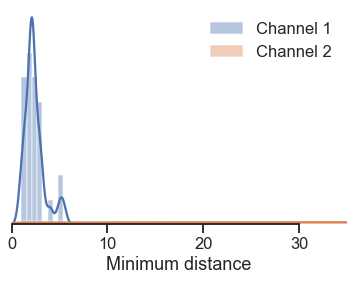

In [55]:
# Extract regions from spots
img1_regions = measure.regionprops(img1_seg)
img2_regions = measure.regionprops(img2_seg)

# Calculate minimum distance between spots
img1_distances = [min([distance(reg1.centroid, reg2.centroid) for reg2 in img2_regions]) for reg1 in img1_regions]
img2_distances = [min([distance(reg2.centroid, reg1.centroid) for reg1 in img1_regions]) for reg2 in img2_regions]

# Visualize
sns.set(style='ticks', context='talk', font='sans-serif')
sns.distplot(img1_distances, label='Channel 1', )
sns.distplot(img2_distances, label='Channel 2')
plt.xlim(0, np.percentile(img1_distances, [90])*10)
plt.yticks([])
plt.xlabel('Minimum distance')
plt.ylabel('')
sns.despine(trim=True, bottom=False, left=True)
plt.legend(frameon=False, loc='best')
plt.show()

## 4. Colocalization analysis
<a id='section4'></a>

There are two main methods of colocaliztion. Intensity based methods such as the pearson correlation coefficient or meanders measure on a pixel-basis. Secondly, object based methods use predefined / segmented objects to give an estimate of colocalization.

As follows, the pearson correlation coefficient and a novel interaction factor will be discussed. The interaction factor combines both approaches and gives an estimate of statistical important as well as the percentage of overlap between two channels.

### 4.1 Pearsons correlation coefficient

The pearson correlation coefficient (PCC) can be used to quantify colocalization with a intensity weight. The equation is shown below.

\begin{align}
r = \frac{\sum_i\left(I_{1,i} - \bar{I}_1\right)\left(I_{2,i} - \bar{I}_2\right)}{\sqrt{\left(\sum_i \left(I_{1,i} - \bar{I}_1\right)^2\right)\left(\sum_i \left(I_{2,i} - \bar{I}_2\right)^2\right)}}.
\end{align}

The image set is tested for statistical relevance i.e. if the colocalization is greater than simple variance. This is done via scrambling small blocks of the image. The blocks' height and width are equal to the point spread function (PSF). The PCC is then calculated on the scrambled image blocks. The PSF can be approximated using the rayleigh criterion, which in case of these images / microscopes is as follows.

\begin{align}
R_{\text{Confocal}} = \frac{0.4 \times \lambda}{\text{NA}} = \frac{0.4 \times 640\text{ nm}}{1.45} = 278\text{ nm} \rightarrow \text{PSF} \approx 3\text{ px}
\end{align}

Due to the fact that the PSF is close to one pixel, every pixel will be scrambled inside the segmented cellular area. Alternatively – if the PSF were larger – the edges would be mirrored to obtain an image that is a multiple of the PSF. This, however, due to the cellular segmentation (resulting in uneven shapes) is not possible. The widget below can be used to visualize the effect of scrambling on the r-value.

For this analysis, the segmented cytoplasm will give the 'real' PCC value. A box around the segmented mask will be scrambled and will provide information on whether the current cell has a statistically accurate PCC value.

In [77]:
def coloc_cellbox(img1, img2, roi, psf=3, scrambles=10):
    # Generate cell boxes
    img1_box = extract_mask(roi, img1, psf)
    img2_box = extract_mask(roi, img2, psf)
    
    # Mirror edges (in case box isn't used)
    #img1_mirror = mirror_edges(img1, psf)
    #img2_mirror = mirror_edges(img2, psf)
    
    # Generate blocks of both channels
    img1_blocks = img_to_blocks(img1_box, psf)
    img2_blocks = img_to_blocks(img1_box, psf)

    # Store blocks of channel 2 as flattened array (not scrambled)
    img2_blocks_flat = np.array(img2_blocks).flatten()

    # Scamblin' and obtain R value
    img1_scr = scramble(img1_blocks, img2_blocks_flat, scrambles)
    
    # Unscrambled R value
    img1_unscr, p = stats.pearsonr(np.array(img1_blocks).ravel(), img2_blocks_flat)
    
    # Probablity
    img1_prob = sum(i > img1_unscr for i in img1_scr) / len(img1_scr)
    
    return img1_scr, img1_prob

In [78]:
def coloc_cellmask(img1, img2):
    r_unscr, _ = stats.pearsonr(img1.flatten(), img2.flatten())
    return r_unscr

In [79]:
@interact(t_scrambles = widgets.IntSlider(min=0, max=2000, step=10, value=10, description='Scrambles: '),
          t_cell = widgets.IntSlider(min=1, max=len(np.unique(img0_seg)), value=1, description='Cell: '))

def g(t_scrambles, t_cell):
    cell_mask = img0_seg==t_cell
    
    t_scr, t_prob = coloc_cellbox(img[1], img[2], cell_mask, scrambles=t_scrambles)
    t_unscr = coloc_cellmask(img[1]*cell_mask, img[2]*cell_mask)
    
    # Visualization
    _ = sns.distplot(t_scr, bins=int(np.sqrt(t_scrambles)), label='Scrambles')
    plt.plot([t_unscr, t_unscr], plt.gca().get_ylim(), '-', label='Real image')
    
    plt.title(f'Scrambled histogram vs. "real" image – Prob: {t_prob}')
    plt.xlabel('Pearson correlation coefficient')
    plt.xlim(-1, 1)
    plt.yticks([])
    plt.ylabel(None)
    plt.legend(frameon=False)
    sns.despine(trim=True, bottom=False, left=True)
    plt.show()

interactive(children=(IntSlider(value=10, description='Scrambles: ', max=2000, step=10), IntSlider(value=1, de…

### 4.2 Interaction factor

The second possibility of quantifying colocalization is using an interaction factor (IF).

The interaction factor was first described in 2017 by Bermudez-Hernandez et al. and combined elements from pixel based co-localization approaches (PCC) and object based approaches. The IF takes cluster / spot masks as an input. By randomly simulating the location of these clusters and taking the frequency of overlaps, one can get a density independent measurement. The actual IF is a value between 0 and 1 with higher values signifying a higher interaction factor. **Note** – as the input requires a spot mask. Therefore, detection methods outputting only coordinates / single pixels must be diluted / masked before usage.

**Converte image to mask**

Image2Mask transforms the input images and ROIs into formats which can be used for the actual interaction factor measurements. The img2mask function outputs a tuple containing the following.

1. Merged RGB image (masked)
2. ROI mask
3. Merged RGB image (original)
4. (Optional – cluster measurements)

In [8]:
cell = 1 # Use non-zero values (0 is background)

ret_images = img2mask((img[1] * img1_seg), (img[2] * img2_seg), (img0_seg==cell))

**Interaction Factor**

This calculates the actual interaction factor. Calculations are performed based on the Scientific Reports paper by Bermudez-Hernandez, Kegan et. al, 2017.

For visualization purposes, two additional parameters get outputed by `IF.calculate_IF()`. These can be used to plot a graph visualizing the calculation process of the interaction factor.

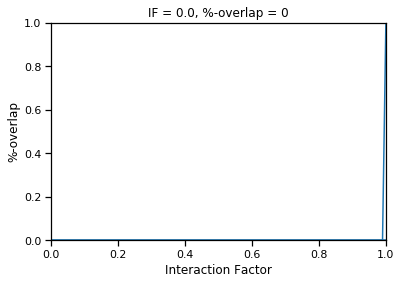

In [13]:
my_IF = IF.interaction_factor(ret_images[0], ret_images[1], ret_images[2])

# Channel 1 as reference
my_IF.ref_color = 0
my_IF.nonref_color = 1
IF1 = my_IF.calculate_IF() # IF, p-value, overlap %
IF1_area = my_IF.orig_area_clusters[0] # total area of clusters ch[i]

# Channel 2 as reference
my_IF.plot_IF_curve = True
my_IF.ref_color = 1
my_IF.nonref_color = 0
IF2 = my_IF.calculate_IF()
IF2_area = my_IF.orig_area_clusters[1]

IF_overlap_count = my_IF.orig_num_ov_clusters
IF_overlap_area = my_IF.orig_area_ov_clusters

# Visualization
plt.axhline(y=IF1[2])
plt.axvline(x=IF1[0], color='red')
plt.title(f'IF = {IF1[0]}, %-overlap = {str(100*round(IF1[2],3))}')
plt.plot(IF1[3], IF1[4], '-')
plt.xlabel('Interaction Factor')
plt.ylabel('%-overlap')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

## 5. Cell-to-cell measurements
<a id='section5'></a>

Depending on the application, slight logical and value changes can occur. At the end of measuring, all values are combined and stored in a .csv file.

**Note** – the following only shows pseudo-code. The actual code is process dependent and can be found in the corresponding excecutable.

```python
columns = ['PARAMETERS TO SAVE']

df = pd.DataFrame(columns=columns)

# Get files
files = get_files_in_directory(DIRECTORY)

for file in files:
    # Import image
    img = import_file_as_image(file)
    
    # Segment
    img0_seg = segment_image(img)
    
    # Spot counting
    img1_seg = spot_count(channel_1)
    img2_seg = spot_count(channel_2)

    for cell in img:
        # Make cell masks
        cell_mask = mask(cell)
        nucleus_mask = mask(cell_nucleus)
        
        # Current spots + measurements
        cell_spots = spots_in_cell(cell_mask)
        spot_distances = get_spot_distance(cell_spots)
        spot_location = get_spot_location(cell_spots)
        spot_intensity = get_spot_intensity(cell_spots)
        
        # Pearson correlation coefficient
        PCC = pearson(cell_mask)
        
        # Interaction factor
        IF = interaction_factor(cell_mask)

        for spot in cell:
            # From spot measurements
            current_spot_info = spot_info[spot]
            
            # Append to dataframe
            df = df.append({'PARAMETERS TO SAVE' : PARAMETERS})

# Save as csv
df.to_csv(f'{OUTFILE}.csv')
```

## 6. Batch processing
<a id='section6'></a>

Batch processing means running complete pipeline over multiple images. All required functions are in the tools.py file. The actual processing file is dependent on the current task. Simply run the following code in the terminal.

```bash
python FILENAME.py -folder='PATH_TO_FOLDER'
```